<a href="https://colab.research.google.com/github/samyeh0527/CNN_BiLSTM_withAttention/blob/master/DualAttention_with_CnnBiGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
   !git clone https://github.com/samyeh0527/CNN_BiLSTM_withAttention.git

Cloning into 'CNN_BiLSTM_withAttention'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 34 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (34/34), done.


In [ ]:
%cd /content/CNN_BiLSTM_withAttention
!ls

/content/CNN_BiLSTM_withAttention
1210雙向注意力機制之深度學習模型應用於石油期貨價格之預測.pdf  Gold_lag4day.csv
Gold_lag13day.csv					      Gold_lag6day.csv
Gold_lag16day.csv					      Gold_lag8day.csv
Gold_lag17day.csv					      OilwithGold.csv
Gold_lag1day.csv					      README.md
Gold_lag2day.csv


In [ ]:
from keras.layers import Input, Dense, LSTM, merge ,Conv1D,Dropout,Bidirectional,Multiply,Concatenate,BatchNormalization,GRU
from keras.models import Model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
from keras.utils.vis_utils import plot_model
from keras import optimizers
import numpy
import  pandas as pd
import math
import datetime
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import backend as K


In [ ]:
#多维NormalizeMult返回數據和最大最小值
import numpy 
import numpy as np
numpy.random.seed(7)
def NormalizeMult(data):
    #normalize 
    data = numpy.array(data)
    normalize = np.arange(2*data.shape[1],dtype='float64')

    normalize = normalize.reshape(data.shape[1],2)
    # print(normalize.shape)
    for i in range(0,data.shape[1]):
        list = data[:,i]
        listlow,listhigh =  np.percentile(list, [0, 100])
        # print(i)
        normalize[i,0] = listlow
        normalize[i,1] = listhigh
        delta = listhigh - listlow
        if delta != 0:
            for j in range(0,data.shape[0]):
                data[j,i]  =  (data[j,i] - listlow)/delta
    #np.save("./normalize.npy",normalize)
    return  data,normalize

#反正規
def FNormalizeMult(data,normalize):
    data = np.array(data)
    for i in  range(0,data.shape[1]):
        listlow =  normalize[i,0]
        listhigh = normalize[i,1]
        delta = listhigh - listlow
        if delta != 0:
            #第j行
            for j in range(0,data.shape[0]):
                data[j,i]  =  data[j,i]*delta + listlow

    return data


(4631, 2)
(515, 2)
(4628, 2, 2) (4628, 2)
(512, 2, 2) (512, 2)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2, 2)]       0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2, 128)       384         input_1[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 128, 2)       0           conv1d[0][0]                     
__________________________________________________________________________________________________
dense (Dense)                   (None, 128, 2)       6           permute[0][0]                    
_______________________________

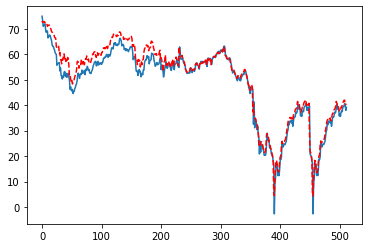

*  FNormalizeMult Test Score: 3.25 RMSE


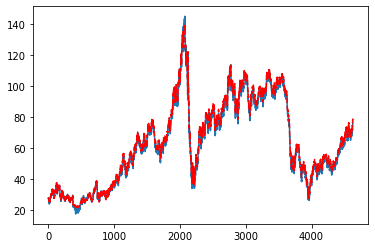

*  FNormalizeMult Train Score: 2.06 RMSE


In [ ]:
#Dual attention with CNNBIGRU
starttime = datetime.datetime.now()

def NormalizeMult(data):
    #normalize 
    data = np.array(data)
    normalize = np.arange(2*data.shape[1],dtype='float64')
    normalize = normalize.reshape(data.shape[1],2)
    # print(normalize.shape)
    for i in range(0,data.shape[1]):
        list = data[:,i]
        listlow,listhigh =  np.percentile(list, [0, 100])
        # print(i)
        normalize[i,0] = listlow
        normalize[i,1] = listhigh
        delta = listhigh - listlow
        if delta != 0:
            for j in range(0,data.shape[0]):
                data[j,i]  =  (data[j,i] - listlow)/delta
    #np.save("./normalize.npy",normalize)
    return  data,normalize

#反正規
def FNormalizeMult(data,normalize):
    data = np.array(data)
    for i in  range(0,data.shape[1]):
        listlow =  normalize[i,0]
        listhigh = normalize[i,1]
        delta = listhigh - listlow
        if delta != 0:
            #第j行
            for j in range(0,data.shape[0]):
                data[j,i]  =  data[j,i]*delta + listlow

    return data
def attention_function(inputs):
   #inputs.shape = (batch_size, TimeSteps, Dims) 
    
    TimeSteps = K.int_shape(inputs)[1]
    a = Permute((2, 1))(inputs)
    a = Dense(TimeSteps, activation='softmax')(a)
    a_probs = Permute((2, 1))(a)
    # element * wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

# convert an array of values into a dataset matrix
def create_dataset2(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),:]
        dataX.append(a)
        dataY.append(dataset[i + look_back,:])
    TrainX = numpy.array(dataX)
    Train_Y = numpy.array(dataY)

    return TrainX, Train_Y 
# fix random seed for reproducibility
numpy.random.seed(1)
# load the dataset
dataframe = read_csv('/content/CNN_BiLSTM_withAttention/OilwithGold.csv')
dataframe = dataframe.drop(['Date'], axis = 1)
dataset = dataframe.values
dataset = dataset.astype('float32')
testVaild=dataset
trainVaild=dataset


# split into train and test sets
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
testVaild = testVaild[train_size:len(dataset),:]
trainVaild = trainVaild[:train_size,:]

print(train.shape)
print(test.shape)
# normalize the dataset
dataset,da_normalize = NormalizeMult(dataset)
train,tr_normalize = NormalizeMult(train)
test,te_normalize = NormalizeMult(test)

look_back = 2
TimeSteps=look_back
Dims=2
trainX, trY = create_dataset2(train, look_back)
testX, teY = create_dataset2(test, look_back)

print(trainX.shape,trY.shape)
print(testX.shape,teY.shape)
trainY,testY =trY[:,0],teY[:,0]

# print(trainY.shape)
# print(testY.shape)


def attention_model():
    inputs = Input(shape=(TimeSteps, Dims))
    x = Conv1D(filters = 128, kernel_size = 1, activation = 'relu')(inputs)  
    attention = attention_function(x)
    BiGRU_out = Bidirectional(GRU(64, return_sequences=True,activation="relu"))(attention)
    Batch_Normalization = BatchNormalization()(BiGRU_out)
    Drop_out = Dropout(0.1)(Batch_Normalization)
    attention = attention_function(Drop_out)
    Batch_Normalization = BatchNormalization()(attention)
    Drop_out = Dropout(0.1)(Batch_Normalization)
    Flatten_ = Flatten()(Drop_out)
    output=Dropout(0.1)(Flatten_)
    output = Dense(1, activation='sigmoid')(output)
    model = Model(inputs=[inputs], outputs=output)
    return model

m = attention_model()
m.summary()
m.compile(loss='mean_squared_error', optimizer='adam')
m.fit(trainX, trainY, epochs=33, batch_size=64, verbose=0,validation_data=(testX, testY))
# make predictions
trainPredict = m.predict(trainX)
testPredict = m.predict(testX)
#FNormalize
trainPredict_FNormalizeMult= FNormalizeMult(trainPredict,tr_normalize)
testPredict_FNormalizeMult= FNormalizeMult(testPredict,te_normalize)

#calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('*  Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('*  Test Score: %.2f RMSE' % (testScore))
teV=testVaild[:-(look_back+1),0] 
trV=trainVaild[:-(look_back+1),0] 
print("D A C BiGRU")
print('*  look_back=',look_back)



# shift test predictions for plotting

                                         
plt.plot(teV)       
plt.plot(testPredict_FNormalizeMult,'r--')
plt.savefig('teV')
plt.show()
testScore = math.sqrt(mean_squared_error(teV, testPredict_FNormalizeMult))
print('*  FNormalizeMult Test Score: %.2f RMSE' % (testScore))
plot_model(m, show_shapes=True, to_file='DualAttention_with_CnnBiGRU.png')
plt.plot(trV)
plt.plot(trainPredict_FNormalizeMult,'r--')
plt.savefig('trV')
plt.show()
trainScore = math.sqrt(mean_squared_error(trV, trainPredict_FNormalizeMult))
print('*  FNormalizeMult Train Score: %.2f RMSE' % (trainScore))



(3602, 2)
(1544, 2)
(3599, 2, 2) (3599, 2)
(1541, 2, 2) (1541, 2)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2, 2)]       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 2, 128)       384         input_2[0][0]                    
__________________________________________________________________________________________________
permute_4 (Permute)             (None, 128, 2)       0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128, 2)       6           permute_4[0][0]                  
_____________________

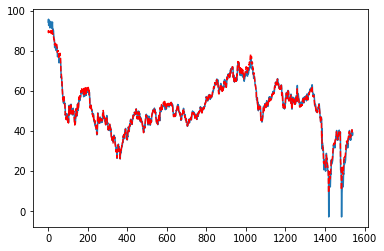

*  FNormalizeMult Test Score: 1.59 RMSE
*  Test Score: 1.07 MAE


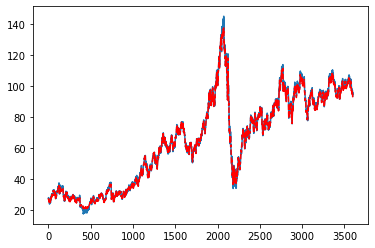

*  FNormalizeMult Train Score: 1.36 RMSE
*  Train Score: 0.95 MAE
*  Test Score: 1.07 MAE


In [ ]:
#Dual attention with CNNBIGRU 
from sklearn.metrics import mean_absolute_error
def NormalizeMult(data):
    #normalize 
    data = np.array(data)
    normalize = np.arange(2*data.shape[1],dtype='float64')
    normalize = normalize.reshape(data.shape[1],2)
    # print(normalize.shape)
    for i in range(0,data.shape[1]):
        list = data[:,i]
        listlow,listhigh =  np.percentile(list, [0, 100])
        # print(i)
        normalize[i,0] = listlow
        normalize[i,1] = listhigh
        delta = listhigh - listlow
        if delta != 0:
            for j in range(0,data.shape[0]):
                data[j,i]  =  (data[j,i] - listlow)/delta
    #np.save("./normalize.npy",normalize)
    return  data,normalize

#反正規
def FNormalizeMult(data,normalize):
    data = np.array(data)
    for i in  range(0,data.shape[1]):
        listlow =  normalize[i,0]
        listhigh = normalize[i,1]
        delta = listhigh - listlow
        if delta != 0:
            #第j行
            for j in range(0,data.shape[0]):
                data[j,i]  =  data[j,i]*delta + listlow

    return data
def attention_function(inputs):
   #inputs.shape = (batch_size, TimeSteps, Dims) 
    
    TimeSteps = K.int_shape(inputs)[1]
    a = Permute((2, 1))(inputs)
    a = Dense(TimeSteps, activation='softmax')(a)
    a_probs = Permute((2, 1))(a)
    # element * wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

# convert an array of values into a dataset matrix
def create_dataset2(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),:]
        dataX.append(a)
        dataY.append(dataset[i + look_back,:])
    TrainX = numpy.array(dataX)
    Train_Y = numpy.array(dataY)

    return TrainX, Train_Y 
# fix random seed for reproducibility
numpy.random.seed(1)
# load the dataset
dataframe = read_csv('/content/CNN_BiLSTM_withAttention/OilwithGold.csv')
dataframe = dataframe.drop(['Date'], axis = 1)
dataset = dataframe.values
dataset = dataset.astype('float32')
testVaild=dataset
trainVaild=dataset

dataset_cut =0.7
# split into train and test sets
train_size = int(len(dataset) * dataset_cut)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
testVaild = testVaild[train_size:len(dataset),:]
trainVaild = trainVaild[:train_size,:]

print(train.shape)
print(test.shape)
# normalize the dataset
dataset,da_normalize = NormalizeMult(dataset)
train,tr_normalize = NormalizeMult(train)
test,te_normalize = NormalizeMult(test)

look_back = 2
TimeSteps=look_back
Dims=2
trainX, trY = create_dataset2(train, look_back)
testX, teY = create_dataset2(test, look_back)

print(trainX.shape,trY.shape)
print(testX.shape,teY.shape)
trainY =trY[:,0]
testY =teY[:,0]
# print(trainY.shape)
# print(testY.shape)


def attention_model():
    inputs = Input(shape=(TimeSteps, Dims))
    x = Conv1D(filters = 128, kernel_size = 1, activation = 'relu')(inputs)  
    attention = attention_function(x)
    BiGRU_out = Bidirectional(GRU(64, return_sequences=True,activation="relu"))(attention)
    Batch_Normalization = BatchNormalization()(BiGRU_out)
    Drop_out = Dropout(0.1)(Batch_Normalization)
    attention = attention_function(Drop_out)
    Batch_Normalization = BatchNormalization()(attention)
    Drop_out = Dropout(0.1)(Batch_Normalization)
    Flatten_ = Flatten()(Drop_out)
    output=Dropout(0.1)(Flatten_)
    output = Dense(1, activation='sigmoid')(output)
    model = Model(inputs=[inputs], outputs=output)
    return model

m = attention_model()
m.summary()
m.compile(loss='mean_squared_error', optimizer='adam')
m.fit(trainX, trainY, epochs=40, batch_size=64, verbose=1,validation_data=(testX, testY))
# make predictions
trainPredict = m.predict(trainX)
testPredict = m.predict(testX)
#FNormalize
trainPredict_FNormalizeMult= FNormalizeMult(trainPredict,tr_normalize)
testPredict_FNormalizeMult= FNormalizeMult(testPredict,te_normalize)

#calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('*  Train Score: %.2f RMSE' % (trainScore))
trainScoreMAE = mean_absolute_error(trainY, trainPredict)
print('*  Train Score: %.2f MAE' % (trainScoreMAE))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('*  Test Score: %.2f RMSE' % (testScore))
testScoreMAE = mean_absolute_error(testY, testPredict)
print('*  Train Score: %.2f MAE' % (testScoreMAE))
teV=testVaild[:-(look_back+1),0] 
trV=trainVaild[:-(look_back+1),0] 
print("D A C BiGRU")
print('*  look_back=',look_back)
print("dataset_cut=",dataset_cut)


# shift test predictions for plotting

                                         
plt.plot(teV)       
plt.plot(testPredict_FNormalizeMult,'r--')
plt.savefig('teV')
plt.show()
testScore = math.sqrt(mean_squared_error(teV, testPredict_FNormalizeMult))
print('*  FNormalizeMult Test Score: %.2f RMSE' % (testScore))
testScoreMAE = mean_absolute_error(teV, testPredict_FNormalizeMult)
print('*  Test Score: %.2f MAE' % (testScoreMAE))

plot_model(m, show_shapes=True, to_file='DualAttention_with_CnnBiGRU.png')
plt.plot(trV)
plt.plot(trainPredict_FNormalizeMult,'r--')
plt.savefig('trV')
plt.show()
trainScore = math.sqrt(mean_squared_error(trV, trainPredict_FNormalizeMult))
print('*  FNormalizeMult Train Score: %.2f RMSE' % (trainScore))
trainScoreMAE = mean_absolute_error(trV, trainPredict_FNormalizeMult)
print('*  Train Score: %.2f MAE' % (trainScoreMAE))
testScoreMAE = mean_absolute_error(teV, testPredict_FNormalizeMult)
print('*  Test Score: %.2f MAE' % (testScoreMAE))


In [ ]:
# import csv
# # 開啟輸出的 CSV 檔案
# with open('testPredict_FNormalizeMult.csv', 'w', newline='') as csvfile:
#   # 建立 CSV 檔寫入器
#   writer = csv.writer(csvfile)
#   writer.writerows(testPredict_FNormalizeMult)
# import numpy
# numpy.savetxt("teV.csv", teV, delimiter=",")
# with open('trainPredict_FNormalizeMult.csv', 'w', newline='') as csvfile:
#   # 建立 CSV 檔寫入器
#   writer = csv.writer(csvfile)
#   writer.writerows(trainPredict_FNormalizeMult)
# numpy.savetxt("trV.csv", trV, delimiter=",")




---
epochs=30
70 train 30 test 
*   Train Score: 0.01 RMSE
*   Test Score: 0.02 RMSE
*   FNormalizeMult Test Score: 1.78 RMSE
---
epochs=30

80 train 20 test 
*  look_back =  2
*  Train Score: 0.03 RMSE
*  Test Score: 0.05 RMSE
*  FNormalizeMult Test Score: 3.90 RMSE
---
epochs=44

80 train 20 test 
*  look_back =  2
*  Train Score: 0.02 RMSE
*  Test Score: 0.03 RMSE
*  FNormalizeMult Train Score: 1.86 RMSE
*  FNormalizeMult Test Score: 1.81 RMSE
---
96 train 4 test
*  loob_back = 2
*   Train Score: 0.02 RMSE
*   Test Score: 0.03 RMSE
*   FNormalizeMult Test Score: 2.36 RMSE
---
*  look_back =  1
*  Train Score: 0.01 RMSE
*  Test Score: 0.07 RMSE
*  FNormalizeMult Test Score: 2.39 RMSE
---
*  loob_back = 3
*  Train Score: 0.02 RMSE
*  Test Score: 0.08 RMSE
*  FNormalizeMult Test Score: 4.18 RMSE
---
*  look_back =  4
*  Train Score: 0.02 RMSE
*  Test Score: 0.07 RMSE
*  FNormalizeMult Test Score: 4.15 RMSE
---
*  look_back =  5
*  Train Score: 0.02 RMSE
*  Test Score: 0.08 RMSE
*  FNormalizeMult Test Score: 5.22 RMSE
---
*  look_back =  6
*  Train Score: 0.02 RMSE
*  Test Score: 0.07 RMSE
*  FNormalizeMult Test Score: 5.21 RMSE
---
*  look_back =  7
*  Train Score: 0.04 RMSE
*  Test Score: 0.08 RMSE
*  FNormalizeMult Test Score: 6.61 RMSE
---
*  loob_back = 8
*  Train Score: 0.03 RMSE
*  Test Score: 0.08 RMSE
*  FNormalizeMult Test Score: 6.69 RMSE

---
*  look_back =  9
*  Train Score: 0.03 RMSE
*  Test Score: 0.07 RMSE
*  FNormalizeMult Test Score: 7.71 RMSE
---
*  look_back =  10
*  Train Score: 0.02 RMSE
*  Test Score: 0.07 RMSE
*  FNormalizeMult Test Score: 8.04 RMSE
---
*  look_back= 11
*  FNormalizeMult Train Score: 4.56 RMSE
*  FNormalizeMult Test Score: 9.24 RMSE
---
*  look_back= 12
*  FNormalizeMult Train Score: 4.52 RMSE
*  FNormalizeMult Test Score: 9.56 RMSE
---
*  look_back= 13
*  FNormalizeMult Train Score: 4.52 RMSE
*  FNormalizeMult Test Score: 10.07 RMSE
---
*  look_back= 14
*  FNormalizeMult Train Score: 4.93 RMSE
*  FNormalizeMult Test Score: 10.75 RMSE
---
*  look_back= 15
*  FNormalizeMult Train Score: 4.86 RMSE
*  FNormalizeMult Test Score: 11.51 RMSE
---
*  look_back= 16
*  FNormalizeMult Train Score: 5.33 RMSE
*  FNormalizeMult Test Score: 11.91 RMSE
---
*  look_back= 17
*  FNormalizeMult Train Score: 8.81 RMSE
*  FNormalizeMult Test Score: 12.70 RMSE
---
*  look_back= 18
*  FNormalizeMult Train Score: 9.73 RMSE
*  FNormalizeMult Test Score: 13.90 RMSE
---
*  look_back= 19
*  FNormalizeMult Train Score: 6.08 RMSE
*  FNormalizeMult Test Score: 13.79 RMSE
---
*  look_back= 20
*  FNormalizeMult Train Score: 7.60 RMSE
*  FNormalizeMult Test Score: 14.01 RMSE

(4631, 2)
(515, 2)
(4628, 2, 2) (4628, 2)
(512, 2, 2) (512, 2)
(4628,)
(512,)
Epoch 1/40
73/73 - 1s - loss: 0.0149 - val_loss: 0.1407
Epoch 2/40
73/73 - 1s - loss: 0.0069 - val_loss: 0.1472
Epoch 3/40
73/73 - 1s - loss: 0.0050 - val_loss: 0.1405
Epoch 4/40
73/73 - 1s - loss: 0.0039 - val_loss: 0.1310
Epoch 5/40
73/73 - 1s - loss: 0.0030 - val_loss: 0.1174
Epoch 6/40
73/73 - 1s - loss: 0.0024 - val_loss: 0.1081
Epoch 7/40
73/73 - 1s - loss: 0.0020 - val_loss: 0.0723
Epoch 8/40
73/73 - 1s - loss: 0.0021 - val_loss: 0.0406
Epoch 9/40
73/73 - 1s - loss: 0.0020 - val_loss: 0.0250
Epoch 10/40
73/73 - 1s - loss: 0.0016 - val_loss: 0.0081
Epoch 11/40
73/73 - 1s - loss: 0.0015 - val_loss: 0.0095
Epoch 12/40
73/73 - 1s - loss: 0.0018 - val_loss: 0.0014
Epoch 13/40
73/73 - 1s - loss: 0.0013 - val_loss: 0.0013
Epoch 14/40
73/73 - 1s - loss: 0.0015 - val_loss: 0.0025
Epoch 15/40
73/73 - 1s - loss: 0.0016 - val_loss: 0.0011
Epoch 16/40
73/73 - 1s - loss: 0.0017 - val_loss: 0.0033
Epoch 17/40
73/73 -

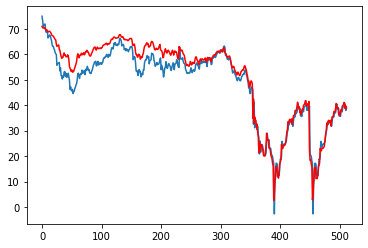

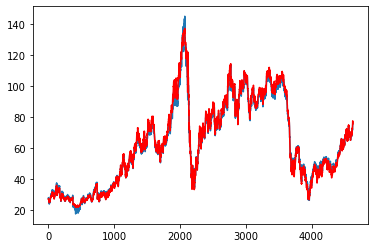

In [ ]:
#Dual Attention with CNNBiLSTM
from keras.layers import Input, Dense, LSTM, merge ,Conv1D,Dropout,Bidirectional,Multiply,Concatenate,BatchNormalization,GRU
from keras.models import Model
from sklearn.metrics import mean_squared_error
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
from keras.utils import plot_model
from keras import optimizers
import numpy
import  pandas as pd
import math
import datetime
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
starttime = datetime.datetime.now()
# convert an array of values into a dataset matrix
def create_dataset2(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),:]
        dataX.append(a)
        dataY.append(dataset[i + look_back,:])
    TrainX = numpy.array(dataX)
    Train_Y = numpy.array(dataY)

    return TrainX, Train_Y 
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('/content/CNN_BiLSTM_withAttention/Gold_lag16day.csv')
dataframe = dataframe.drop(['Date'], axis = 1)
dataset = dataframe.values
dataset = dataset.astype('float32')
testVaild=dataset
trainVaild=dataset


# split into train and test sets
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
testVaild = testVaild[train_size:len(dataset),:]
trainVaild = trainVaild[:train_size,:]
print(train.shape)
print(test.shape)
# normalize the dataset
dataset,da_normalize = NormalizeMult(dataset)
train,tr_normalize = NormalizeMult(train)
test,te_normalize = NormalizeMult(test)

look_back = 2
TimeSteps=look_back
Dims=2
trainX, trY = create_dataset2(train, look_back)
testX, teY = create_dataset2(test, look_back)
print(trainX.shape,trY.shape)
print(testX.shape,teY.shape)
trainY =trY[:,0]
testY =teY[:,0]
print(trainY.shape)
print(testY.shape)
plot_model(m, show_shapes=True, to_file='DualAttention_with_CnnBiLSTM.png')


def attention_model():
    inputs = Input(shape=(TimeSteps, Dims))
    x = Conv1D(filters = 128, kernel_size = 2, activation = 'relu')(inputs)  
    attention = attention_function(x)
    Bilstm_out = Bidirectional(LSTM(64, return_sequences=True,activation="relu"))(attention)
    Batch_Normalization = BatchNormalization()(Bilstm_out)
    Drop_out = Dropout(0.1)(Batch_Normalization)
    attention = attention_function(Drop_out)
    Batch_Normalization = BatchNormalization()(attention)
    Drop_out = Dropout(0.1)(Batch_Normalization)
    Flatten_ = Flatten()(Drop_out)
    output=Dropout(0.1)(Flatten_)
    output = Dense(1, activation='sigmoid')(output)
    model = Model(inputs=[inputs], outputs=output)
    return model

m = attention_model()
# m.summary()
m.compile(loss='mean_squared_error', optimizer='adam')
m.fit(trainX, trainY, epochs=40, batch_size=64, verbose=2,validation_data=(testX, testY))
# make predictions
trainPredict = m.predict(trainX)
testPredict = m.predict(testX)
#FNormalize
trainPredict_FNormalizeMult= FNormalizeMult(trainPredict,tr_normalize)
testPredict_FNormalizeMult= FNormalizeMult(testPredict,te_normalize)


#calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('*  Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('*  Test Score: %.2f RMSE' % (testScore))
teV=testVaild[:-(look_back+1),0] 
trV=trainVaild[:-(look_back+1),0] 
print("DA CNN BiLSTM")
print("---")
print('*  look_back=',look_back)
trainScore = math.sqrt(mean_squared_error(trV, trainPredict_FNormalizeMult))
print('*  FNormalizeMult Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(teV, testPredict_FNormalizeMult))
print('*  FNormalizeMult Test Score: %.2f RMSE' % (testScore))
trainScoreMAE = mean_absolute_error(trV, trainPredict_FNormalizeMult)
print('*  Train Score: %.2f MAE' % (trainScoreMAE))
testScoreMAE = mean_absolute_error(teV, testPredict_FNormalizeMult)
print('*  Test Score: %.2f MAE' % (testScoreMAE))
# shift test predictions for plotting
print("test plt")                                          
plt.plot(teV)       
plt.plot(testPredict_FNormalizeMult,'r')
plt.show()
plot_model(m, show_shapes=True, to_file='DualAttention_with_CnnBiLSTM.png')
plt.plot(trV)
plt.plot(trainPredict_FNormalizeMult,'r')
plt.show()


96 train 4 test   DualATT with LSTM
*  loob_back = 1
*  Train Score: 0.03 RMSE
*  Test Score: 0.06 RMSE
*  FNormalizeMult Test Score: 2.23 RMSE
---
*  loob_back = 2
*   Train Score: 0.02 RMSE
*   Test Score: 0.03 RMSE
*   FNormalizeMult Test Score: 3.31 RMSE

---
*  loob_back = 3
*  Train Score: 0.02 RMSE
*  Test Score: 0.08 RMSE
*  FNormalizeMult Test Score: 3.61 RMSE
---
*  loob_back = 4
*  Train Score: 0.02 RMSE
*  Test Score: 0.07 RMSE
*  FNormalizeMult Test Score: 3.62 RMSE
---
*  loob_back = 5
*  Train Score: 0.02 RMSE
*  Test Score: 0.07 RMSE
*  FNormalizeMult Test Score: 4.82 RMSE
---
*  loob_back = 6
*  Train Score: 0.03 RMSE
*  Test Score: 0.07 RMSE
*  FNormalizeMult Test Score: 5.51 RMSE
 
---
*  loob_back = 7
*  Train Score: 0.02 RMSE
*  Test Score: 0.08 RMSE
*  FNormalizeMult Test Score: 6.10 RMSE
---
*  loob_back = 8
*  Train Score: 0.02 RMSE
*  Test Score: 0.08 RMSE
*  FNormalizeMult Test Score: 6.31 RMSE
---
*  loob_back = 9
*  Train Score: 0.02 RMSE
*  Test Score: 0.07 RMSE
*  FNormalizeMult Test Score: 7.62 RMSE
---
*  loob_back = 10
*  Train Score: 0.02 RMSE
*  Test Score: 0.08 RMSE
*  FNormalizeMult Test Score: 7.67 RMSE
---
*  look_back= 11
*  FNormalizeMult Train Score: 4.66 RMSE
*  FNormalizeMult Test Score: 8.49 RMSE
---

*  look_back= 12
*  FNormalizeMult Train Score: 4.32 RMSE
*  FNormalizeMult Test Score: 9.43 RMSE
---
*  look_back= 13
*  FNormalizeMult Train Score: 4.44 RMSE
*  FNormalizeMult Test Score: 10.11 RMSE
---
*  look_back= 14
*  FNormalizeMult Train Score: 4.65 RMSE
*  FNormalizeMult Test Score: 10.57 RMSE
---
*  look_back= 15
*  FNormalizeMult Train Score: 5.01 RMSE
*  FNormalizeMult Test Score: 11.08 RMSE
---

*  look_back= 16
*  FNormalizeMult Train Score: 4.97 RMSE
*  FNormalizeMult Test Score: 11.75 RMSE
---

*  look_back= 17
*  FNormalizeMult Train Score: 5.28 RMSE
*  FNormalizeMult Test Score: 12.36 RMSE
---
*  look_back= 18
*  FNormalizeMult Train Score: 5.51 RMSE
*  FNormalizeMult Test Score: 12.70 RMSE
---
*  look_back= 19
*  FNormalizeMult Train Score: 5.84 RMSE
*  FNormalizeMult Test Score: 13.07 RMSE
---
---
*  look_back= 20
*  FNormalizeMult Train Score: 6.13 RMSE
*  FNormalizeMult Test Score: 13.37 RMSE